In [20]:
import tensorflow as tf
from sklearn import datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

In [21]:
iris = datasets.load_iris()
features = iris['data']
target = iris['target']
N = len(target)
shuffle_index = np.arange(len(target))
np.random.shuffle(shuffle_index)
features = features[shuffle_index, :]
target = target[shuffle_index]

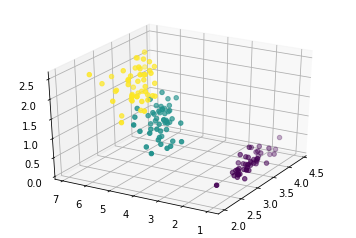

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features[:,1], features[:, 2], features[:, 3], c=target)
ax.view_init(30, 210)
plt.show()

In [23]:
TRAIN_SIZE = 120
train_x, test_x = features[:TRAIN_SIZE], features[TRAIN_SIZE:]
train_y, test_y = target[:TRAIN_SIZE], target[TRAIN_SIZE:]

In [35]:
slices = tf.data.Dataset.from_tensor_slices(({'feat0': train_x[:,0],
                                              'feat1': train_x[:, 1],
                                              'feat2': train_x[:, 2],
                                              'feat3': train_x[:, 2]},
                                             train_y))

In [39]:
print(slices)

<TensorSliceDataset shapes: ({feat0: (), feat1: (), feat2: (), feat3: ()}, ()), types: ({feat0: tf.float64, feat1: tf.float64, feat2: tf.float64, feat3: tf.float64}, tf.int64)>


In [45]:
def train_input_fn(features, labels, batch_size=128):
    # Can do all features as one:
    # dataset = tf.data.Dataset.from_tensor_slices(({'feats': features}, labels))
    # Or separate "columns":
    dataset = tf.data.Dataset.from_tensor_slices(({'feat0': features[:,0],
                                             'feat1': features[:, 1],
                                             'feat2': features[:, 2],
                                              'feat3': features[:, 2]},
                                            labels))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset

In [46]:
train_input_fn(train_x, train_y)

<BatchDataset shapes: ({feat0: (?,), feat1: (?,), feat2: (?,), feat3: (?,)}, (?,)), types: ({feat0: tf.float64, feat1: tf.float64, feat2: tf.float64, feat3: tf.float64}, tf.int64)>

In [47]:
my_feature_columns = []
for key in ['feat0', 'feat1', 'feat2', 'feat3']:
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [48]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10],
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgirinxhe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3b9c7e68d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [4]:
import pandas as pd
import tensorflow as tf

TRAIN_URL = "http://download.tensorflow.org/data/iris_training.csv"
TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
                    'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

def maybe_download():
    train_path = tf.keras.utils.get_file(TRAIN_URL.split('/')[-1], TRAIN_URL)
    test_path = tf.keras.utils.get_file(TEST_URL.split('/')[-1], TEST_URL)

    return train_path, test_path

def load_data(y_name='Species'):
    """Returns the iris dataset as (train_x, train_y), (test_x, test_y)."""
    train_path, test_path = maybe_download()

    train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
    train_x, train_y = train, train.pop(y_name)

    test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
    test_x, test_y = test, test.pop(y_name)

    return (train_x, train_y), (test_x, test_y)


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset


# The remainder of this file contains a simple example of a csv parser,
#     implemented using the `Dataset` class.

# `tf.parse_csv` sets the types of the outputs to match the examples given in
#     the `record_defaults` argument.
CSV_TYPES = [[0.0], [0.0], [0.0], [0.0], [0]]

def _parse_line(line):
    # Decode the line into its fields
    fields = tf.decode_csv(line, record_defaults=CSV_TYPES)

    # Pack the result into a dictionary
    features = dict(zip(CSV_COLUMN_NAMES, fields))

    # Separate the label from the features
    label = features.pop('Species')

    return features, label


def csv_input_fn(csv_path, batch_size):
    # Create a dataset containing the text lines.
    dataset = tf.data.TextLineDataset(csv_path).skip(1)

    # Parse each line.
    dataset = dataset.map(_parse_line)

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [7]:
(train_x, train_y), (test_x, test_y) = load_data()

In [17]:
# More on feature column:
# https://www.tensorflow.org/guide/feature_columns
